## Introduction to Supervised Modeling for Shakespeare/Non-Shakespeare Classification

In this notebook I am proceed with classification techniques in order to label plays as Shakespeare or not Shakespeare, performing an authorship attribution task. 

In [1]:
# importing libraries for importing files, modeling, storing model performance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from gensim.models import word2vec

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, f1_score, confusion_matrix,\
        accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

import scikitplot as skplt
from scikitplot.metrics import plot_roc_curve

from sklearn.pipeline import Pipeline

import xgboost as xgb

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, GRU
from keras.layers import Dropout, Activation, GlobalMaxPool1D
from keras.models import Sequential, load_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

import random
np.random.seed(0)

import warnings 
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# importing data from pickle files
with open('data/pickle_jar.pickle', 'rb') as f:
    pickle_jar = pickle.load(f)
    
X_train = pickle_jar[0]
X_test = pickle_jar[1]
y_train = pickle_jar[2]
y_test = pickle_jar[3]
X_train_50 = pickle_jar[4]
X_test_50 = pickle_jar[5]
X_train_ngrams = pickle_jar[6]
X_test_ngrams = pickle_jar[7]
train_lemmatized = pickle_jar[8]
test_lemmatized = pickle_jar[9]
train_tokens = pickle_jar[10]
test_tokens = pickle_jar[11]

In [3]:
# creating lists to evaluate model performance
model_names = []
f1_list = []
accuracy_list = []
precision_list = []
recall_list = []

def evaluate_performance(y_true, y_pred, model_name):
    # adding performance metrics to lists
    model_names.append(model_name)
    f1_list.append(round(f1_score(y_true, y_pred), 4))
    accuracy_list.append(round(accuracy_score(y_true, y_pred), 4))
    precision_list.append(round(precision_score(y_true, y_pred), 4))
    recall_list.append(round(recall_score(y_true, y_pred), 4))

    # printing performance metrics
    print(classification_report(y_true, y_pred, target_names=['Not Shakespeare', 'Shakespeare']))

## Creating Vector Representations using GloVe

I am also generating one last representation of my data using Global Vectors for Word Representation (GloVe). This generates a vector for each word in our corpus, and places similar words close together. I want to make the weights usable with sklearn. The GloVe 6B data is available at [NLP Stanford](https://nlp.stanford.edu/projects/glove/). These weights are trained on 6B tokens with a 400K vocab. Each vector size is 300 dimensions.

In [4]:
# importing GloVe weights for words in our vocabulary into dictionary
total_vocabulary = set(word for play in train_tokens for word in play)

embeddings_index = {}
with open('glove.6B/glove.6B.300d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings_index[word] = vector
            
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(embeddings_index))])
    
# make class usable with sklearn pipeline
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

## Creating GloVe Sequences that can be used with RNN

In [5]:
# using Keras to create sequences for use with RNN
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_lemmatized)
word_index = tokenizer.word_index

train_tokenized = tokenizer.texts_to_sequences(train_lemmatized)
train_sequences = sequence.pad_sequences(train_tokenized, maxlen=100)

test_tokenized = tokenizer.texts_to_sequences(test_lemmatized)
test_sequences = sequence.pad_sequences(test_tokenized, maxlen=100)

In [6]:
# creating a weight matrix for our vocabulary
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Random Forest 

I am first using a Random Forest model with a GridSearch to identify the best hyperparameters. A Random Forest is an ensemble model composed of Decision Trees(a single classifier that uses a tree-like structure to sort data, resulting in a classification decision at each terminal node). I am initializing the model with 100 trees and using cross validation to reduce the chance of overfitting the model. For this first model I am using all three vecetor representations of my data.

## Using Full TF-IDF

In [7]:
# creating Random Forest with 100 "trees"
rf_classifier = RandomForestClassifier(n_estimators=100)

# assembling GridSearch
grid = [{'max_depth': [25, 50, 100, None], 
         'min_samples_split': [2, 4, 8], 
         'min_samples_leaf': [1, 3, 5]}]

RF_gridsearch = GridSearchCV(estimator=rf_classifier,
                          param_grid=grid,
                          scoring='accuracy',
                          cv=5,
                          return_train_score=True)

# Fit the training data
RF_gridsearch.fit(X_train, y_train)
y_pred_test = RF_gridsearch.predict(X_test)
y_pred_train = RF_gridsearch.predict(X_train)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_pred_test, 'RF_TF-IDF')                  

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.90      1.00      0.95         9
    Shakespeare       1.00      0.89      0.94         9

       accuracy                           0.94        18
      macro avg       0.95      0.94      0.94        18
   weighted avg       0.95      0.94      0.94        18



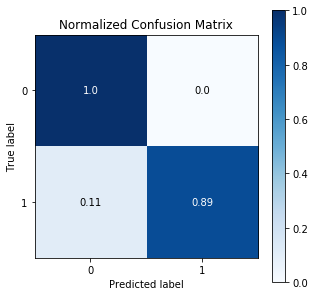

In [8]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

## Using Dimensionality-Reduced TF-IDF

In [9]:
# fitting the training data
RF_gridsearch.fit(X_train_50, y_train)
y_pred_test = RF_gridsearch.predict(X_test_50)
y_pred_train = RF_gridsearch.predict(X_train_50)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_pred_test, 'RF_Dim-Reduc')                  

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.50      1.00      0.67         9
    Shakespeare       0.00      0.00      0.00         9

       accuracy                           0.50        18
      macro avg       0.25      0.50      0.33        18
   weighted avg       0.25      0.50      0.33        18



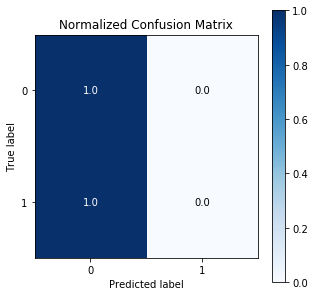

In [10]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

## Using Bigram TF-IDF

In [11]:
# fitting the training data
RF_gridsearch.fit(X_train_ngrams, y_train)
y_pred_test = RF_gridsearch.predict(X_test_ngrams)
y_pred_train = RF_gridsearch.predict(X_train_ngrams)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_pred_test, 'RF_ngrams')                 

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.64      1.00      0.78         9
    Shakespeare       1.00      0.44      0.62         9

       accuracy                           0.72        18
      macro avg       0.82      0.72      0.70        18
   weighted avg       0.82      0.72      0.70        18



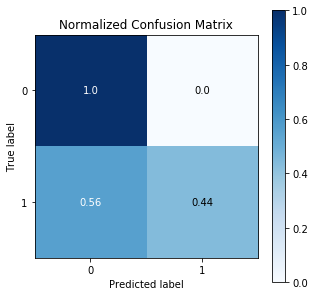

In [12]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

The Random Forest performed best using the full set of unigrams, achieving an accuracy of 94%, with a recall of 89% on my target class. The dimensionality reduced data performed very poorly, and did not identify any of our 18 texts as Shakespeare. 

# Naive Bayes

The next classifier I am using is Naive Bayes, which is a probability-based method of determining class. However, as the model assumes independence of each of our features, and performs on multiclass problems I had my doubts on whether this would be able to make high accuracy predictions.

## Multinomial Bayes Using Full TF-IDF

In [13]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)
y_train_preds = nb_classifier.predict(X_train)
y_test_preds = nb_classifier.predict(X_test)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_pred_test, 'MNB_TF-IDF')    

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.64      1.00      0.78         9
    Shakespeare       1.00      0.44      0.62         9

       accuracy                           0.72        18
      macro avg       0.82      0.72      0.70        18
   weighted avg       0.82      0.72      0.70        18



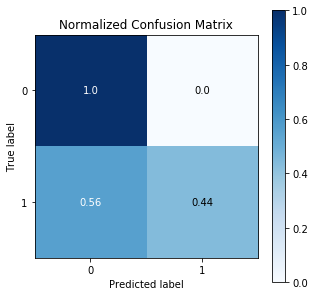

In [14]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

## Complement Naive Bayes Using Fall TF-IDF

I am also fitting a Complement Naive Bayes, an adaptation of the above standard Multinomial Naive Bayes algorithm, often outperforming it when it comes to text classification problems. This algorithm uses the complement of each class to compute weights, making it particularly suited for imbalanced data sets. We only have a slight class imbalance here. 

In [15]:
cnb = ComplementNB()

cnb.fit(X_train, y_train)
y_train_preds = cnb.predict(X_train)
y_test_preds = cnb.predict(X_test)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_pred_test, 'CNB_TF-IDF')  

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.64      1.00      0.78         9
    Shakespeare       1.00      0.44      0.62         9

       accuracy                           0.72        18
      macro avg       0.82      0.72      0.70        18
   weighted avg       0.82      0.72      0.70        18



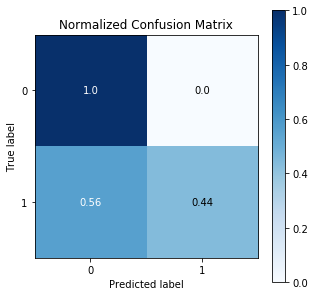

In [16]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

Neither of our Naive Bayes algorithms performed particularly well - they performed the same on our full TF-IDF data. These classifiers are not often the highest performing, so it is not surprising that these are outpaced by the Random Forest thusfar.

# Support Vector Machine (SVM)

The next model I am using identifies a hyperplane that divides our datapoints by class. A SVM should hopefully be effective given the high dimensionality of our data. 

## Using Dimensionality Reduced TF-IDF

In [17]:
# initializing SVM classifier with a linear kernel (recommended for text classification)
svm_classifier = SVC(C=1, kernel='linear', gamma='auto')
svm_classifier.fit(X_train_50, y_train)
y_train_preds = svm_classifier.predict(X_train_50)
y_test_preds = svm_classifier.predict(X_test_50)

print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_test_preds, 'SVM_Dim-Red')

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.56      1.00      0.72         9
    Shakespeare       1.00      0.22      0.36         9

       accuracy                           0.61        18
      macro avg       0.78      0.61      0.54        18
   weighted avg       0.78      0.61      0.54        18



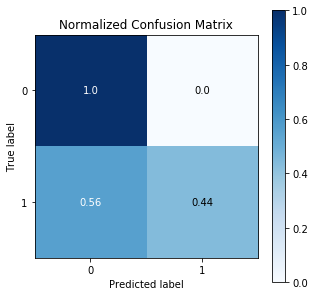

In [18]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

## Using TF-IDF of Bigrams

In [19]:
# using our classifier with the same parameters and fitting to ngrams
svm_classifier.fit(X_train_ngrams, y_train)
y_train_preds = svm_classifier.predict(X_train_ngrams)
y_test_preds = svm_classifier.predict(X_test_ngrams)

print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_test_preds, 'SVM_bigrams')

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       0.60      1.00      0.75         9
    Shakespeare       1.00      0.33      0.50         9

       accuracy                           0.67        18
      macro avg       0.80      0.67      0.62        18
   weighted avg       0.80      0.67      0.62        18



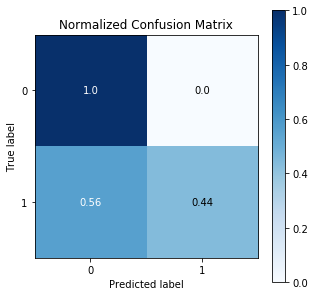

In [20]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

# XGBoost

The last of my machine learning models before I delve into deep learning is  XGBoost. XGBoost functions by using gradient boosted trees, and like Random Forest is an ensemble method. Unlike Random Forest, it works iteratively to correct the errors of prior trees to minimize loss with small information gains achieved with each tree.

## Using Default Params and Unigrams

In [21]:
# creating XGBoost classifier using default params
xgb_classifier = xgb.XGBClassifier()

# fitting model
xgb_classifier.fit(X_train, y_train)
y_train_preds = xgb_classifier.predict(X_train)
y_test_preds = xgb_classifier.predict(X_test)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_test_preds, 'XGB_TF-IDF')     

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       1.00      1.00      1.00         9
    Shakespeare       1.00      1.00      1.00         9

       accuracy                           1.00        18
      macro avg       1.00      1.00      1.00        18
   weighted avg       1.00      1.00      1.00        18



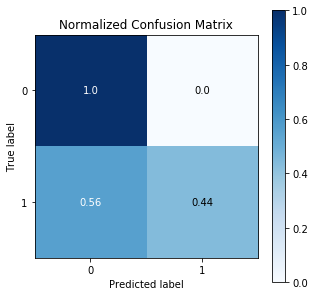

In [22]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

## Using W2V and Glove Weights

In [23]:
#  fitting XGBoost pipleline using vectorizer
XGB_pipeline = Pipeline([('Word2Vec', W2vVectorizer(embeddings_index)),
                         ('xgb', xgb.XGBClassifier())])

XGB_grid = [{'xgb__learning_rate': [0.001, 0.002],
            'xgb__max_depth': [5, 10, 15, 20],
            'xgb__min_child_weight': [1, 3, 5],
            'xgb__n_estimators': [100, 150, 200]}]

XGB_gridsearch = GridSearchCV(XGB_pipeline,
                              XGB_grid,
                              scoring='accuracy',
                              cv=5,
                              n_jobs=1)
XGB_gridsearch.fit(train_sequences, y_train)
y_pred_test = XGB_gridsearch.predict(test_sequences)
y_pred_train = XGB_gridsearch.predict(train_sequences)

# evaluating performance
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_pred_test, 'XGB_seq')           

Accuracy Score for Training Data: 0.5775
                 precision    recall  f1-score   support

Not Shakespeare       0.50      1.00      0.67         9
    Shakespeare       0.00      0.00      0.00         9

       accuracy                           0.50        18
      macro avg       0.25      0.50      0.33        18
   weighted avg       0.25      0.50      0.33        18



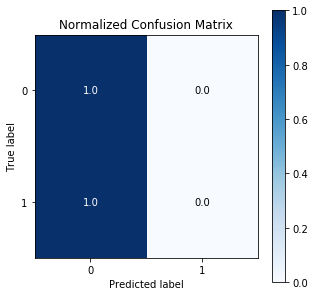

In [24]:
# viewing confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, figsize=(5,5), normalize=True)

# RNNs

My last model type is a Long Short Term Memory(LSTM) Recurrent Neural Network with Gated Recurrent Units, meaning each cell retains better short-term memory of what has been learned in order to minimize loss. A GRU tempers this with a reset gate and an update gate, determining relevant/irrelevant information, and how much to keep. 

## GloVe Pretrained Weights
I am using the mean embedded vectorization using by the GloVe pre-trained weights as set up in the introduction.

In [25]:
# importing EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# defining stopping criterion
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_model.h5', verbose=2, monitor='val_loss', save_best_only=True)]

In [26]:
# building RNN with word embeddings and LSTM neurons
model = Sequential()

model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False))
model.add(LSTM(256, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
# showing summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         13014300  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         570368    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
__________

In [28]:
# fitting RNN with validation split
history = model.fit(train_sequences,
                    y_train,
                    epochs=50,
                    callbacks=early_stopping,
                    batch_size=5,
                    validation_split=0.30)

Train on 49 samples, validate on 22 samples
Epoch 1/50
49/49 [==============================] - 1s 20ms/step - loss: 0.6745 - acc: 0.6327 - val_loss: 0.9897 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.98968, saving model to best_model.h5
Epoch 2/50
49/49 [==============================] - 1s 11ms/step - loss: 0.6343 - acc: 0.6327 - val_loss: 1.1246 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.98968
Epoch 3/50
49/49 [==============================] - 1s 11ms/step - loss: 0.5692 - acc: 0.6939 - val_loss: 0.6333 - val_acc: 0.7273

Epoch 00003: val_loss improved from 0.98968 to 0.63331, saving model to best_model.h5
Epoch 4/50
49/49 [==============================] - 1s 11ms/step - loss: 0.4728 - acc: 0.8163 - val_loss: 1.0372 - val_acc: 0.1364

Epoch 00004: val_loss did not improve from 0.63331
Epoch 5/50
49/49 [==============================] - 1s 11ms/step - loss: 0.3808 - acc: 0.8571 - val_loss: 0.5751 - val_acc: 0.6818

Epoch 00005: val_l

In [29]:
# loading saved model
from keras.models import load_model
saved_model = load_model('best_model.h5')

# generating predictions for RNN
y_pred_test = saved_model.predict_classes(test_sequences)
y_pred_train = saved_model.predict_classes(train_sequences)
print(f'Accuracy Score for Training Data: {round(accuracy_score(y_train, y_pred_train), 4)}')
evaluate_performance(y_test, y_test_preds, 'RNN')     

Accuracy Score for Training Data: 1.0
                 precision    recall  f1-score   support

Not Shakespeare       1.00      1.00      1.00         9
    Shakespeare       1.00      1.00      1.00         9

       accuracy                           1.00        18
      macro avg       1.00      1.00      1.00        18
   weighted avg       1.00      1.00      1.00        18



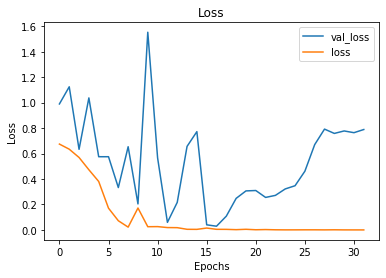

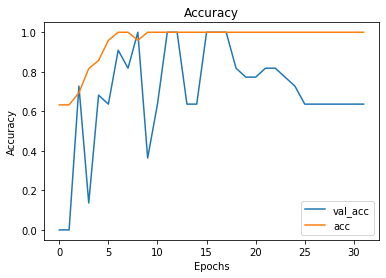

In [30]:
# defining function to visualize model performance
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
# displaying model performance
visualize_training_results(history)

In [32]:
# showing final dataframe
model_df = pd.DataFrame({'Model_Name': model_names,
                         'F1_Score': f1_list,
                         'Accuracy_Score': accuracy_list,
                         'Precision_Score':precision_list,
                         'Recall_Score':recall_list})
model_df.style.background_gradient(cmap='Blues')

,Model_Name,F1_Score,Accuracy_Score,Precision_Score,Recall_Score
0,RF_TF-IDF,0.9412,0.9444,1,0.8889
1,RF_Dim-Reduc,0,0.5,0,0
2,RF_ngrams,0.6154,0.7222,1,0.4444
3,MNB_TF-IDF,0.6154,0.7222,1,0.4444
4,CNB_TF-IDF,0.6154,0.7222,1,0.4444
5,SVM_Dim-Red,0.3636,0.6111,1,0.2222
6,SVM_bigrams,0.5,0.6667,1,0.3333
7,XGB_TF-IDF,1,1,1,1
8,XGB_seq,0,0.5,0,0
9,RNN,1,1,1,1


# Conclusion

As we can see from this model performance summary, the best performing models by far were the XGboost and the RNN. There were a number of models that were attempted or iterated over - for example, I tuned the RNN with both GRU and LSTM neurons a number of times seeking better results, ensuring that the model was not overfit. It is surprising that most of my models achieved such high precision and abysmal recall, so they did not predict false positives with a high tradeoff of many false negatives.